In [2]:
from src.Autoencoder import Autoencoder
from src.Dataloader import Dataloader 
import torch
from torchvision.transforms import ToTensor
model = Autoencoder(4)
dataloader = Dataloader("Datasets/Dataset003/Train",24, 224, 224, True)
# dataloader = Dataloader("Datasets/Dataset002/Train",4, 224, 224, False)

n_images = 4
images = dataloader.load_images(dataloader.path, n_images)
# print('Loaded images shape:', np.array(images).shape)
images = dataloader.greyscale_images(images)
# print('Greyscale images shape:', np.array(images).shape)
images = dataloader.layer_images(images, n_images)

# Normalize the images to the range [0, 1]
images = images / 255.0
print ('Layered images shape:', images.shape)
images = torch.tensor(images, dtype=torch.float32)




Layered images shape: (500, 4, 224, 224)


In [4]:
from torch.utils.data import random_split

# Define the loss function and optimizer

if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
    model.cuda()# Move the model to the GPU
else:
    print("CUDA is not available. Using CPU.")
    model.cpu()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

BS = 16
# Split the dataset into training and testing datasets
train_size = int(0.8 * len(images))
test_size = len(images) - train_size
train_dataset, test_dataset = random_split(images, [train_size, test_size])

# Create DataLoaders for training and testing datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BS, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BS, shuffle=True)

print('Train dataset size:', len(train_dataset))

print(type(train_loader))
print(train_loader.dataset[0].shape)

CUDA is not available. Using CPU.
Train dataset size: 400
<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([4, 224, 224])


Input shape: torch.Size([500, 4, 224, 224])
Output shape: torch.Size([1, 4, 224, 224])


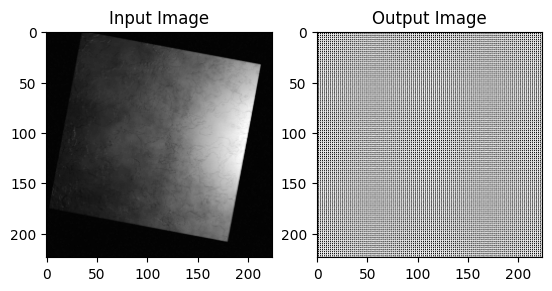

In [6]:
# One forward pass
img = train_loader.dataset[0].unsqueeze(0)

output = model(img.cuda()) if torch.cuda.is_available() else model(img)

print("Input shape:", images.shape)
print("Output shape:", output.shape)

# print(image[0].detach().numpy())
from matplotlib import pyplot as plt
plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(images[0][0].detach().numpy(), cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Output Image')
plt.imshow(output[0][0].cpu().detach().numpy(), cmap='gray')
plt.show()

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
# Define a list to store training loss and validation loss
Loss = []
Validation_Loss = []


num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set model to training mode
    # for img, _ in train_loader:
    for idx, img in enumerate(train_loader):
        # print('img shape:', img.shape)
        img = img.cuda() if torch.cuda.is_available() else img
        
        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad() #clears the gradients of all optimized tensors.  This step is necessary because gradients are accumulated by default in PyTorch, and we want to compute fresh gradients for the current batch of data.
        loss.backward() # This line computes the gradients of the loss function with respect to the model parameters. These gradients are used to update the model parameters during optimization.
        optimizer.step() # This line updates the model parameters using the computed gradients. 
    Loss.append(loss.item())
       

    # Calculate validation loss
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_loss_sum = 0.0
        num_batches = 0
        for idx, img in enumerate(test_loader):
            img = img.cuda() if torch.cuda.is_available() else img
            output = model(img)
            val_loss = criterion(output, img)
            val_loss_sum += val_loss.item()
            num_batches += 1
        val_loss_avg = val_loss_sum / num_batches
        Validation_Loss.append(val_loss_avg)
    
    if epoch % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item(), val_loss_avg))

plt.plot(Loss, label='Training Loss')
plt.plot(Validation_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

AssertionError: Torch not compiled with CUDA enabled

In [47]:
# Save the model
torch.save(model.state_dict(), 'autoencoder.pth')

In [8]:
# Load the model
model.load_state_dict(torch.load('autoencoder.pth', map_location='cpu'))
model.eval()  # Set model to evaluation mode

C:\Users\Caspe\AppData\Local\Temp\ipykernel_13072\1371881077.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('autoencoder.pth', map_loca

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(64, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): Sigmoid()
  )
)

torch.Size([16, 224, 224])


<Figure size 1600x1200 with 0 Axes>

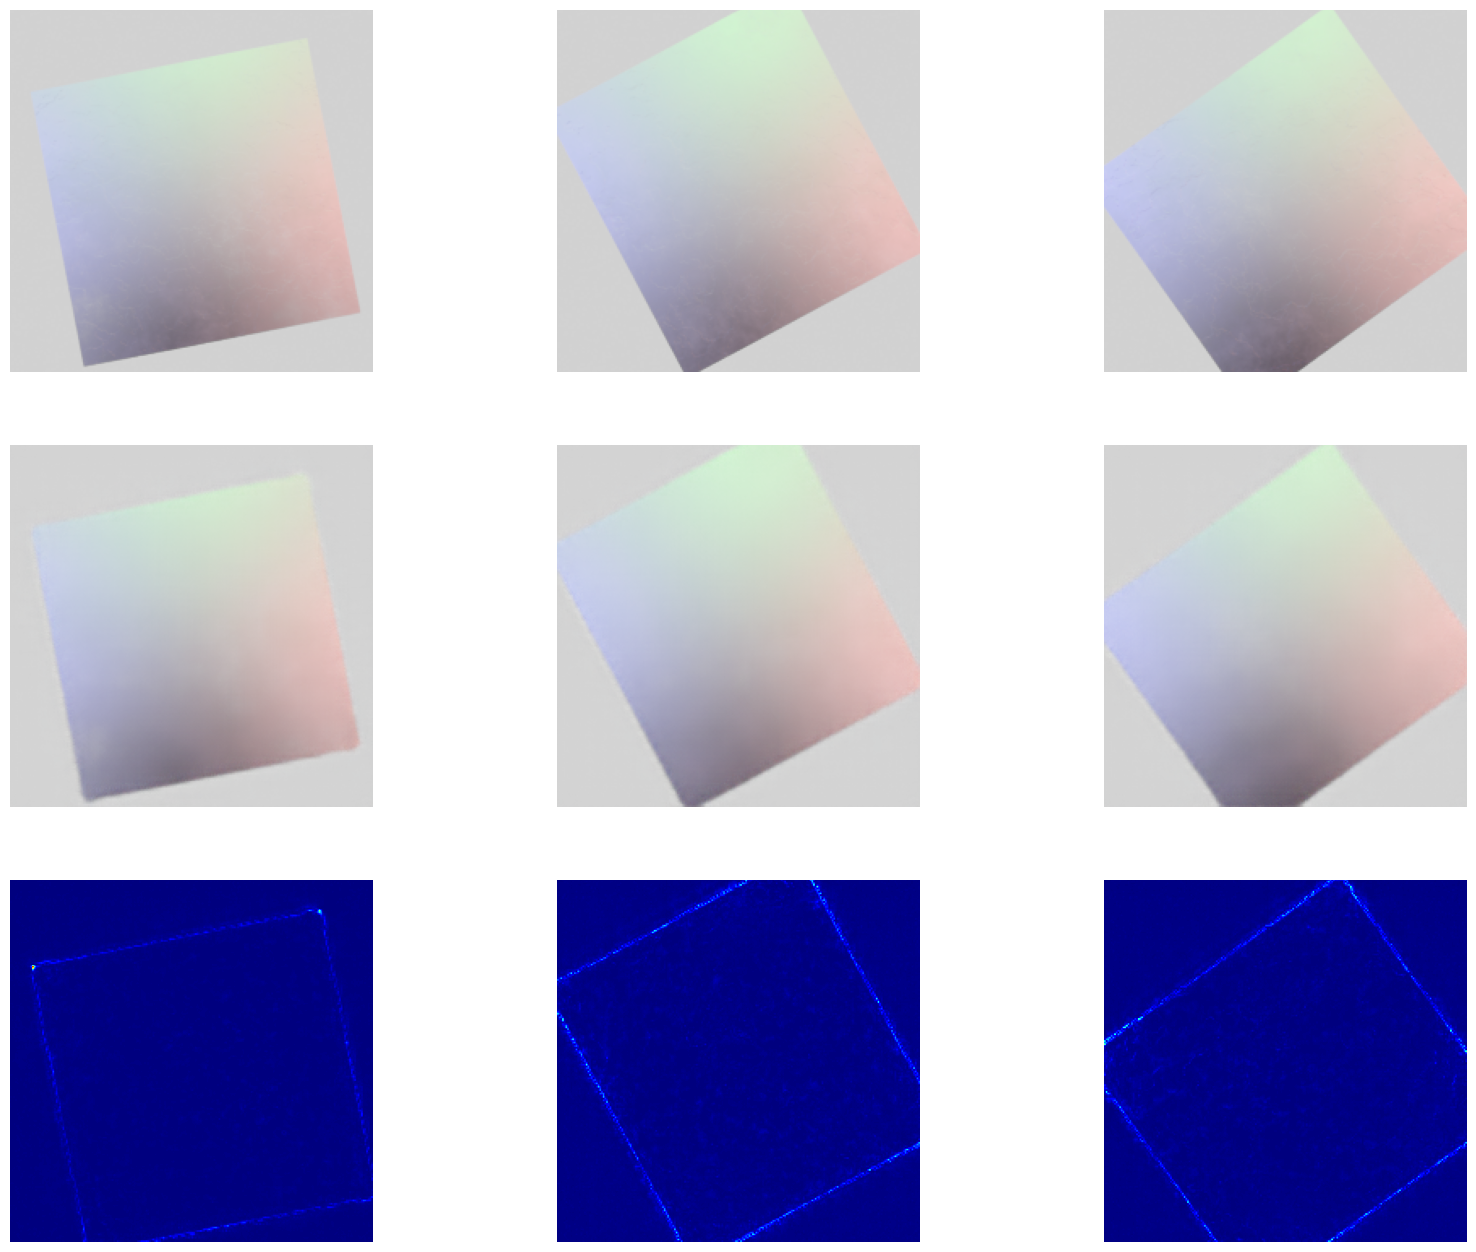

In [10]:
with torch.no_grad():
    for idx, data in enumerate(train_loader):
        data = data.cuda() if torch.cuda.is_available() else data
        recon = model(data)
        break

# latent_space = model.encoded
# print(latent_space.shape)

recon_error =  ((data-recon)**2).mean(axis=1)
print(recon_error.shape)

plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10,0:-10].cpu().numpy(), cmap='jet',vmax= torch.max(recon_error[i])) #[0:-10,0:-10]
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
plt.show()
    

data shape: (224, 224)


<Figure size 1600x1200 with 0 Axes>

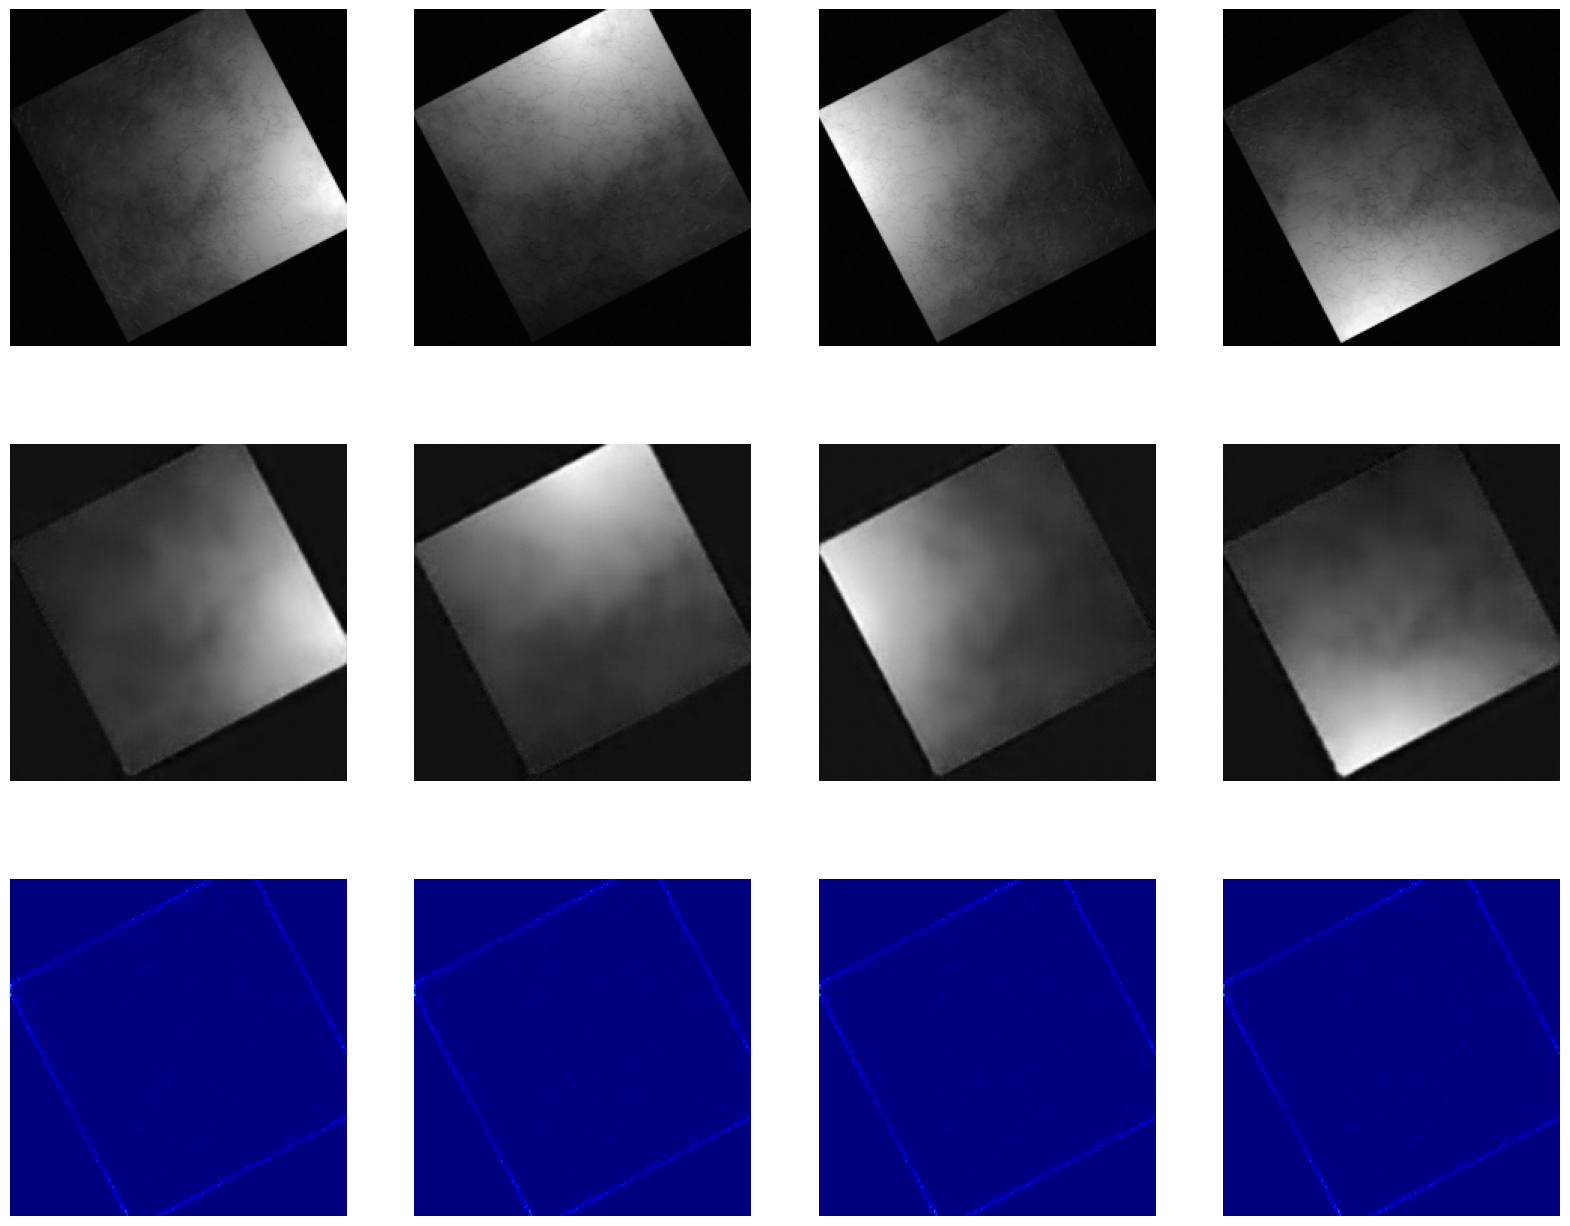

In [ ]:
# from src.hypespectral_plotter import plot_hyperspectral_image
import numpy as np
def plot_hyperspectral_image(data, recon, recon_error, title="Hyperspectral Image"):
    
    print('data shape:',data[0].shape)
    tensor = torch.tensor(data[0])
    plt.figure(dpi=250)
    fig, ax = plt.subplots(3, data.shape[0], figsize=(5*4, 4*4))
    for i in range(data.shape[0]):
        ax[0, i].imshow(data[i], cmap='gray')
        ax[1, i].imshow(recon[i], cmap='gray')
        ax[2, i].imshow(recon_error[0:-10,0:-10], cmap='jet',vmax= torch.max(torch.tensor(recon_error))) #[0:-10,0:-10]
        ax[0, i].axis('OFF')
        ax[1, i].axis('OFF')
        ax[2, i].axis('OFF')
    plt.show()

plot_hyperspectral_image(data[0].cpu().numpy(), recon[0].cpu().numpy(), recon_error[0].cpu().numpy(),
                        title='Hyperspectral Image Reconstruction Error')